# Labelling tool for mobile eye tracking data

This code will read the raw data from the Pupil server and will give you different outputs that can be flexibly managed: 

1. **Saccades** (based on a adapted version of [Niehorster et al., 2020](https://link.springer.com/article/10.3758/s13428-019-01314-1))
2. **Smooth eye movements** (pursuit and VOR)
3. **Fixations** (as the absence of a detected movement)
3. **Head Movements** 
4. **Automatic Scene Labelling** with Detectron2 [(Wu et al., 2019)](https://github.com/facebookresearch/detectron2)

With this you can analyze basic eye and head movement characteristics (Frequencies, amplitudes, Fixation Durations, ...) <br> as well as a good approximation what people where fixating in the real world.


## Import relevant packages

In [1]:
# Remove warnings
import warnings
warnings.filterwarnings("ignore")

# Import packages
import os
import pandas as pd
import numpy as np
import cv2
import json
#import ffmpegcv 
from scipy import signal
from sys import platform
from itertools import compress 
from itertools import count
import glob


# Plotting thigs
import matplotlib.pyplot as plt
import matplotlib.patches as pltrec
from matplotlib.widgets import Slider, Button, CheckButtons
import ipympl

# Import the analysis functions 
import AnalysisTools as at

# Setup Detectron
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # Run the setup logger 
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Setup Depth Estimattion 
from unidepth.models import UniDepthV1
from PIL import Image

# Get system name 
SystemName  = platform

##########################################################################
## setting paths 
abspath = os.path.abspath('Main.ipynb') # Get the Path of this script
dname = os.path.dirname(abspath) # Get the directory
os.chdir(dname) # Set this to your current working directoy

## Define some global parameters of the analysis

Here we will set some thresholds etc that are then used in the following analysis


In [2]:
global SamplingRateEye,SamplingRateHead,WindowLength,Threshold,MaxCounter,MinFix,Lambda, UpperThreshold,MinThreshold,MinDurationPursuit,MinVelocityPrctile,MinVelocityPursuit,MinDurationHead,MinVelocityPrctileHead,MinVelocityHead,WindowLengthHead,DirectionWindow,DistanceWindow,IntegrationRadius

# Sampling Rates
SamplingRateEye = 200 # Sampling rate of the eye tracking Data data in [Hz]
SamplingRateHead= 110 # Sampling rate of the eye tracking Data data in [Hz]

# For the saccade detection
WindowLength = 1000 # Length of the window you search for fixations [ms]
Threshold = 200 # Initial Threshold velocity to start searching 
MaxCounter = 200 # Number of iterations for outlier search 
MinFix = 80 # Minimum Duration for Fixation [ms]
Lambda = 2.5 # Std Criterion for outlier search 
UpperThreshold = 1200 # Upper Velocity Threshold
MinThreshold = 50 # Lower Velocity Threshold
MissThreshold = 100 # Lower Velocity Threshold

# For smooth movement detection 
MinDurationPursuit = 100 # Minimum Duration of smooth segment
MinVelocityPrctile = 68 # Minimum Velocity of Pursuit 
MinVelocityPursuit = 10 # Minimum Velocity of Pursuit 

# For head movement detection 
MinDurationHead = 100 # Minimum Duration of segment for head movement
MinVelocityPrctileHead= 68 # Minimum Velocity of Head movement within window 
MinVelocityHead = 10 # Minimum Velocity of Head 
WindowLengthHead = 2000 # Length of the window you search for fixations [ms]

# For VOR 
DirectionWindow = 30 # The direction of the eye and head movement need to be in 180 +/- the Window [°] 
DistanceWindow = 0.5 # The ratio of the eye and head distance coverd in the respective time needs to be 1- Distance Window (e.g. if 0.5 it needs to be between 50 and 150%)

# For scene labelling
IntegrationRadius =30 # Pixel radius that is considered to be fixated


## Now load the data

Data Structure should be as follows. Per Recording, there should be one folder that has the following files: 
1. gaze.csv 
2. imu.csv
3. world_timestamps.csv
4. world.mp4 (This file is typically named differently, for ease of use it should be renamed to world)



In [3]:
# Define the datapath to the data
Datapath = '../Data/' # Data should be a folder on the same level as the Code Folder

### Set the Name of the recording you want to analyze 
# Rec = 'Subj15/Images'
Rec = 'TestWorld_handstand'

######################################################
# Get the behavioural data 
Eye = pd.read_csv(os.path.join(Datapath,Rec,'gaze.csv')) # Get the gaze position
Eye3D = pd.read_csv(os.path.join(Datapath,Rec,'3d_eye_states.csv')) # Get the gaze position

Head = pd.read_csv(os.path.join(Datapath,Rec,'imu.csv')) # Get the Head position via the imu data
Video = pd.read_csv(os.path.join(Datapath,Rec,'world_timestamps.csv')) # Get the timestamps of the video 
LabelList = pd.read_json(os.path.join(Datapath,'panoptic_coco_categories.json')) # Read the list of the labels for Image Segmentation

# Find the video 
vidname = glob.glob(os.path.join(Datapath,Rec,'*.mp4'))
cap = cv2.VideoCapture(vidname[0]) # World Video

########################################################################################
## Add toggles to decide what to analyze 
AnalyzeSacc = 1 # if 1 you will label saccades 
AnalyzeSmooth = 1 # if 1 you will label smooth eye movements
AnalyzeHead = 1 # if 1 you will analyze head movements
AnalyzeBlinks =1 # if 1 you will save the blinks
IntFigureLabel = 1 # if 1 you will show the labeling figure 
AnalyzeSceneLabelling = 0 # if 1 you want to analyze the scene camera
DepthLabelling = 1 # if 1 you want to analyze the scene camera

Visualize = 0 # if 1 you will try to visualize the results 


#### Run some tests to check the data recordings 

In [4]:
at.test_dataformats(Eye,Head,Video,cap) # test whether the shape of the data is correct

## Read out the variables you need for the analysis and compute velocities

Things you want to have: 
1. Gaze position in pixels and degrees and their sampling 
2. The head position in deg 

Then compute the eye and head velocity (this is already available for the head movements).
For computing the eye velocity, you want to add a filter to the gaze data to reduce noise.
Also get the sampling of the different components and align them on the same time scale.



In [5]:
""" This is for the isolated eye movements """

## Get the relevant Data 
xpos = Eye['gaze x [px]'].to_numpy() # Eye position in pixel x 
ypos = Eye['gaze y [px]'].to_numpy() # Eye position in pixel y 
xdeg = Eye['azimuth [deg]'].to_numpy() # Eye position in pixel x 
ydeg = Eye['elevation [deg]'].to_numpy() # Eye position in pixel y 
time_eye= Eye['timestamp [ns]'].to_numpy()/10**6 # Timestamps of the eye recording divided by 10^6 to turn it into ms

## Setup the Filter 
b,a = signal.butter(2, 20, 'low', fs=200, output='ba')

## Filter the eye data
xpos = signal.filtfilt(b,a,xpos) # Xpos in Pixel
ypos = signal.filtfilt(b,a,ypos) # Ypos in Pixel
xdeg = signal.filtfilt(b,a,xdeg) # Xpos in Deg
ydeg = signal.filtfilt(b,a,ydeg) # Ypos in Deg

## Compute the velocity 
# Velocity in deg per second
vel_x = at.HesselsVelocity(xdeg,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_y = at.HesselsVelocity(ydeg,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_eye = np.hypot(vel_x,vel_y)
#vel_eye = signal.filtfilt(b,a,vel_eye) # Xpos in Pixel

# Velocity in Pixel per second
vel_x_pix = at.HesselsVelocity(xpos,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_y_pix = at.HesselsVelocity(ypos,time_eye)*1000 # Mulitply it by 1000 to make it deg/s
vel_eye_pix = np.hypot(vel_x_pix,vel_y_pix)



In [6]:
""" This is for the isolated head movements """

PitchDeg = Head['pitch [deg]'].to_numpy() # Read out the positions in deg
YawDeg = Head['yaw [deg]'].to_numpy()
RollDeg = Head['roll [deg]'].to_numpy()
time_head = Head['timestamp [ns]'].to_numpy()/10**6

vx_head = Head['gyro z [deg/s]'].to_numpy() *-1 # The velocities are already available from the gyroscope
vy_head = Head['gyro x [deg/s]'].to_numpy()
vz_head = Head['gyro y [deg/s]'].to_numpy()
v_head = np.hypot(vx_head,vy_head) # 2d velocity in x and y plane relative to camera




In [7]:
## Align the timings 

time_video = Video['timestamp [ns]'].to_numpy()/10**6 # Get the timing from the video file 

info = []
with open(Datapath+Rec + "/info.json", "r") as f:
    info = json.load(f)
NormTime =info["start_time"]/10**6# Define a common start point, the initial frame of the eye recording 

# Update the time variables
time_eye = time_eye-NormTime 
time_video = time_video-NormTime
time_head = time_head-NormTime

In [8]:
""" Now also represent eye and head together in world coordinates"""

# Resample the head signal to match the gaze signal
quaternions_resampled = np.array(
    [
        np.interp(time_eye, time_head, Head["quaternion x"]),
        np.interp(time_eye, time_head, Head["quaternion y"]),
        np.interp(time_eye, time_head, Head["quaternion z"]),
        np.interp(time_eye, time_head, Head["quaternion w"]),
    ]
).T


# Now, we can apply the functions --> see https://docs.pupil-labs.com/alpha-lab/imu-transformations/
headings_in_world = at.imu_heading_in_world(quaternions_resampled)

cart_gazes_in_world = at.gaze_3d_to_world(
    ydeg, xdeg, quaternions_resampled
)

[world_head_elevation, world_head_azimuth] = at.cartesian_to_spherical_world(headings_in_world)
[world_gaze_elevation, world_gaze_azimuth] = at.cartesian_to_spherical_world(cart_gazes_in_world)


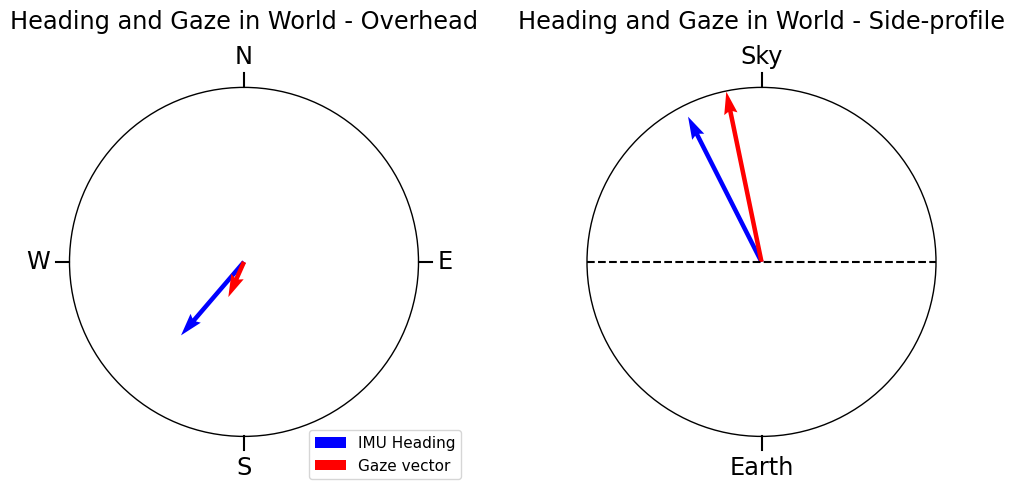

In [19]:
%matplotlib inline
at.VisualizeWorldVector(headings_in_world,cart_gazes_in_world,1200)

In [12]:
## BaselineCorrection: 
world_gaze_azimuth_corrected = (world_gaze_azimuth)#-np.median(world_gaze_azimuth[500:1000]))*-1
world_head_azimuth_corrected = (world_head_azimuth)#-np.median(world_head_azimuth[500:1000]))*-1

b,a = signal.butter(2, 20, 'low', fs=200, output='ba')
world_gaze_azimuth_corrected = signal.filtfilt(b,a,world_gaze_azimuth_corrected) # Xpos in Deg
world_head_azimuth_corrected = signal.filtfilt(b,a,world_head_azimuth_corrected)

plt.plot(world_gaze_azimuth_corrected)
plt.plot(world_head_azimuth_corrected)


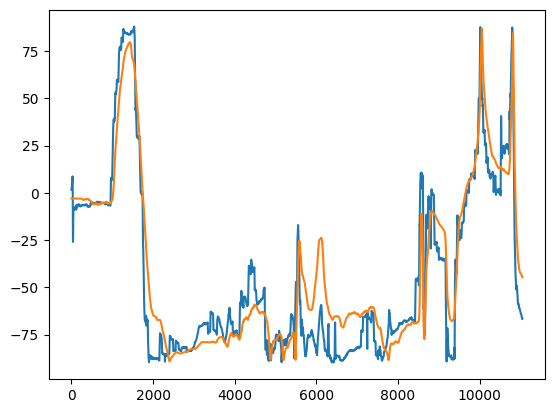

In [11]:
plt.plot(world_gaze_elevation)
plt.plot(world_head_elevation)

In [ ]:
## Correct for Blinks, in the raw file from Pupil Labls these are interpolated and existent
xpos[np.where(Eye['blink id'].notnull())] = np.nan
ypos[np.where(Eye['blink id'].notnull())] = np.nan
xdeg[np.where(Eye['blink id'].notnull())] = np.nan
ydeg[np.where(Eye['blink id'].notnull())] = np.nan
vel_eye[np.where(Eye['blink id'].notnull())] = np.nan
Blink_Vek = (Eye['blink id'].notnull())

In [7]:
## Define the intervall of the analysis 

Start = np.min(time_eye)/1000 # Time of start in [s]
End =  np.max(time_eye)/1000 # Time of end in [s]

## Save the eye velocity 
Data = np.zeros((len(time_eye),2))
Data[:,0] = time_eye
Data[:,1] = vel_eye
df = pd.DataFrame(Data,columns = ['time [ms]', 'velocity [deg/s]'])
df.to_csv(os.path.join(Datapath,Rec,'EyeVelocity.csv'), index=False)

## Movement Labelling

For that we will take the position and velocity of the eye and head, to identify movements 


### The saccade Labelling algogrithm 

In [8]:
if AnalyzeBlinks:

    # Define some interval to not run it on the whole code
    on_eye = 0
    off_eye = np.max(np.where(time_eye < End*1000))

    # Get the indexes for the blinks 
    BlinkVek = np.array(Eye['blink id'].to_numpy())
    NumBlink = np.nanmax(BlinkVek)

    BlinkOn = []
    BlinkOff= []
    BlinkOnIdx= []
    BlinkOffIdx= []

    for aa in np.arange(1,NumBlink+1): # Find Blink onsets and offsets
        Check = np.where(BlinkVek ==aa )
        On = np.min(Check[0])
        Off = np.max(Check[0])
        BlinkOn.append(time_eye[On])
        BlinkOff.append(time_eye[Off])
        BlinkOnIdx.append(On)
        BlinkOffIdx.append(Off)

    BlinkLabels = at.compute_parameter_blinks(xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],BlinkOn,BlinkOff,BlinkOnIdx,BlinkOffIdx,Datapath,Rec)

In [9]:
if AnalyzeSacc:

    # Define some interval to not run it on the whole code
    on_eye = np.min(np.where(time_eye > Start*1000))
    off_eye = np.max(np.where(time_eye < End*1000))

    # Finding potential intervals 
    [Saccon,Saccoff,SaccOnIdx,SaccOffIdx,thr] = at.SaccadeLabelling(xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],time_eye[on_eye:off_eye],globals()['WindowLength'],globals()['Threshold'],globals()['MaxCounter'],globals()['MinFix'],globals()['Lambda'],globals()['SamplingRateEye'])

    # Check wethere these are actually saccades 
    [UpdtSaccon,UpdtSaccoff,UpdtSacconIdx,UpdtSaccoffIdx] = at.CheckSacc(SaccOnIdx,SaccOffIdx,Saccon,Saccoff,vel_eye[on_eye:off_eye],xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],time_eye[on_eye:off_eye],globals()["UpperThreshold"],globals()["MinThreshold"])

    SaccOn_temp = UpdtSaccon
    [UpdtSaccon,UpdtSaccoff,UpdtSacconIdx,UpdtSaccoffIdx] = at.CheckMisses(UpdtSaccon,UpdtSaccoff,UpdtSacconIdx,UpdtSaccoffIdx,vel_eye[on_eye:off_eye],xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],time_eye[on_eye:off_eye],globals()["MissThreshold"])
    
    # Collect the saccades and respective parameter and save them to the data folder, last argument gives option to see main sequence figure
    SaccLabels = at.compute_parameter_sacc(xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],UpdtSaccon,UpdtSaccoff,UpdtSacconIdx,UpdtSaccoffIdx,Datapath,Rec)

...... Finding Thresholds ....
...... Finding Fixations ....
...... Identifiying Saccades ....


### The smooth eye movement labelling algorithm 

In [10]:
if AnalyzeSacc and AnalyzeSmooth:
    print('... Finding Smooth Eye Movement Segments ....')
    # Find smooth movements
    [PursOn,PursOff,PursOnIdx,PursOffIdx]= at.FindSmooth(xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],time_eye[on_eye:off_eye],UpdtSacconIdx,UpdtSaccoffIdx,globals()['MinDurationPursuit'],globals()['MinVelocityPursuit'],globals()['MinVelocityPrctile'],globals()['SamplingRateEye'])

    if len(PursOn) > 0: # If you found pursuit elements
        # Check the smooth movements and update them 
        [PursOn,PursOff,PursOnIdx,PursOffIdx]= at.CheckSmooth(PursOn,PursOff,PursOnIdx,PursOffIdx,UpdtSacconIdx,globals()['MinFix'])

        # Do this twice so that you catch some intervalls where there are two things to merch 
        [PursOn,PursOff,PursOnIdx,PursOffIdx]= at.CheckSmooth(PursOn,PursOff,PursOnIdx,PursOffIdx,UpdtSacconIdx,globals()['MinFix'])


... Finding Smooth Eye Movement Segments ....


### The head movement labeling algorithm 

In [11]:
if AnalyzeHead:
    print('... Finding Head Movement Segments ....')

    # Define some interval to not run it on the whole code
    on_head = np.min(np.where(time_head > Start*1000))
    off_head = np.max(np.where(time_head < End*1000))
    
    [HeadOnset, HeadOffset,HeadOnIdx,HeadOffIdx]= at.FindHead(v_head[on_head:off_head],time_head[on_head:off_head],globals()['WindowLengthHead'],globals()['MinVelocityPrctileHead'],globals()['MinVelocityHead'],globals()['MinDurationHead']) # Label the head movements

    [HeadOnset, HeadOffset,HeadOnIdx,HeadOffIdx]= at.CheckHead(HeadOnset, HeadOffset,HeadOnIdx,HeadOffIdx,globals()['MinFix']) # Check whethter they are valid 

    [HeadOnset, HeadOffset,HeadOnIdx,HeadOffIdx]= at.CheckHead(HeadOnset, HeadOffset,HeadOnIdx,HeadOffIdx,globals()['MinFix']) # Do it twice


... Finding Head Movement Segments ....


### Combine head and eye movements to classify VOR movements

In [12]:
if AnalyzeSmooth:

    print('... Distinguishing Pursuit and VOR ....')

    [VOR,Pursuit] = at.CheckVOR(time_eye[on_eye:off_eye],PursOnIdx,PursOffIdx,vel_x[on_eye:off_eye],vel_y[on_eye:off_eye],time_head,vx_head,vy_head,globals()['SamplingRateEye'],globals()['SamplingRateHead'],globals()['DirectionWindow'],globals()['DistanceWindow'])

    # Divide the smooth labels into pursuit and VOR 
    VOROn =PursOn[VOR]
    VOROff =PursOff[VOR]
    VOROnIdx =PursOnIdx[VOR]
    VOROffIdx =PursOffIdx[VOR]

    PursOn = PursOn[Pursuit]
    PursOff = PursOff[Pursuit]
    PursOnIdx = PursOnIdx[Pursuit]
    PursOffIdx = PursOffIdx[Pursuit]

    

... Distinguishing Pursuit and VOR ....


#### Save the pursuit, VOR and head movement parameter

In [13]:
## Now save the parameter of the detected movements 

print('... Saving Data ....')

if AnalyzeSmooth:
    at.compute_parameter_purs(xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],PursOn,PursOff,PursOnIdx,PursOffIdx,Datapath,Rec)

    at.compute_parameter_vor(xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],vx_head,vy_head,VOROn,VOROff,VOROnIdx,VOROffIdx,time_head,time_eye[on_eye:off_eye],Datapath,Rec,globals()['SamplingRateHead'])

if AnalyzeHead: 
    at.compute_parameter_head(vx_head[on_head:off_head],vy_head[on_head:off_head],HeadOnset, HeadOffset,HeadOnIdx,HeadOffIdx,Datapath,Rec,globals()['SamplingRateHead'])

if AnalyzeSacc and AnalyzeSmooth:
    [FixOn, FixOff] = at.compute_parameter_fix(xpos[on_eye:off_eye],ypos[on_eye:off_eye],xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],time_eye[on_eye:off_eye],PursOnIdx,PursOffIdx,UpdtSacconIdx,UpdtSaccoffIdx,VOROnIdx,VOROffIdx,Blink_Vek[on_eye:off_eye],Datapath,Rec,globals()['MinFix'])

... Saving Data ....


### Visualize the movement labeling 

In [15]:
# Visualize things
if IntFigureLabel:
    %matplotlib widget
    at.CreateInteractiveFigure(time_eye[on_eye:off_eye],xdeg[on_eye:off_eye],ydeg[on_eye:off_eye],vel_eye[on_eye:off_eye],time_head[on_head:off_head],vx_head[on_head:off_head],vy_head[on_head:off_head],vz_head[on_head:off_head],UpdtSaccon,UpdtSaccoff,PursOn,PursOff,HeadOnset,HeadOffset,VOROn,VOROff,FixOn,FixOff)

## Explanation of the labels: 
# Shaded red area: Saccades
# Shaded blue area: pursuit 
# Shaded green area: VOR 
# Shaded yellow area: Head Movement

## Scene Labelling 

For the scene labelling use Detectron to label the individual frames 
--> Output should be a matrix that contains the objects that are fixated within each frame, as well as a baseline that shows how many pixel belogned to each category 


In [ ]:
"""Here you can analyze the scene camera """
if AnalyzeSceneLabelling:
    Start_time = 10 # Start in time [s]
    End_time = 11.5 # End in time [s]
           
    Start = np.min(np.where(time_video > Start_time*1000))
    End = np.max(np.where(time_video< End_time*1000))

    [MatFix,MatObj] = at.SceneLabelling(Start,End,time_video,time_eye,xpos,ypos,Datapath,Rec,SystemName,globals()['IntegrationRadius'])


## Depth Estimation

For the video data use UniDepth to compute the depth for individual frames
--> Output should be a vector containing the fixated depth for each frame

In [ ]:
if DepthLabelling:
        
    Start_time = np.min(time_video)/1000 # Time of start in [s]
    End_time =  np.max(time_video)/1000 # Time of end in [s]
            
    Start = np.min(np.where(time_video > Start_time*1000))
    End = np.max(np.where(time_video< End_time*1000))

    DepthVek = at.DepthLabelling(Start,End,time_video,time_eye,xpos,ypos,Datapath,Rec)

    ## Save the Depth Map
    Data = np.zeros((len(time_video[Start:End])+1,2))
    Data[:,0] = time_video[Start-1:End]
    Data[:,1] = DepthVek.ravel()
    df = pd.DataFrame(Data,columns = ['time [ms]', 'Depth [m]'])
    df.to_csv(os.path.join(Datapath,Rec,'DepthMap.csv'), index=False)
        
  

## Create Visualizations

List of Visualizations: 
1. Video + Overlayed Gaze
2. Video + Movement Labels as Bars 
3. Video + Highlighted fixated Object 
4. Video + All Objects 
5. Video + Gaze over Depth Map


### 1. Video + Overlayed Gaze

This function will create a video that shows the scene camera with overlayed gaze position.

In [ ]:
"""Visualization for Video with overlayed Gaze"""
Start_time = 0 # Start in time [s]
End_time = 30 # End in time [s]

Start = np.min(np.where(time_video > Start_time*1000))
End = np.max(np.where(time_video< End_time*1000))
print(Start,End)
Resultpath = '../Visualizations'
at.CreateVideoGazeOverlay(Datapath,Resultpath,Rec,Start,End,xpos,ypos,time_eye,time_video)


### 2. Video + Gaze + Labelled Movements

In this video, you will see the overlaid gaze video, plus 4 bars on each side of the screen:  
* If the top is illuminated red, a saccade ocurred. 
* If the left is illuminated magenta, a VOR movement
* If the right is illuminated blue, a pursuit movement
* if the bottom is illuminated cyan a head movement

In [ ]:
"""Visualization for Video with overlayed Gaze"""
# Start_time = np.min(time_video) # Start in time [s]
# End_time = np.max(time_video) # End in time [s]
    
# Start = np.min(np.where(time_video > Start_time*1000))
# End = np.max(np.where(time_video< End_time*1000))

# Resultpath = '../Visualizations'
# at.CreateVideoGazeOverlayLabels(Datapath,Resultpath,Rec,Start,End,xpos,ypos,time_eye,time_video,time_head,UpdtSaccon,UpdtSaccoff,PursOn,PursOff,VOROn,VOROff,HeadOnset,HeadOffset)

### 3. Video + Highlighted Object

Here we use Detectron to segment and label objects. The video is as the classical gaze overlay, but additionally the object that is fixated is highlighted automatically.

In [ ]:
"""Visualization for Video with highlighted Object"""

Start_time = 0 # Start in time [s]
End_time = 15 # End in time [s]
    
Start = np.min(np.where(time_video > Start_time*1000))
End = np.max(np.where(time_video< End_time*1000))

Resultpath = '../Visualizations'
at.CreateVideoHighlightObject(Datapath,Resultpath,Rec,Start,End,xpos,ypos,time_eye,time_video,SystemName,LabelList,0)

### 4. Video + Segmented Objects

Here we use Detectron to segment and label all objects. The video is as the classical gaze overlay, but additionally each object that is in the scene is color coded and shown

In [ ]:
"""Visualization for Video with highlighted Object"""
Start_time = 250 # Start in time [s]
End_time = 280 # End in time [s]
    
Start = np.min(np.where(time_video > Start_time*1000))
End = np.max(np.where(time_video< End_time*1000))

Resultpath = '../Visualizations'
#at.CreateVideoSegmentObject(Datapath,Resultpath,Rec,Start,End,xpos,ypos,time_eye,time_video,SystemName,LabelList,0)

### 5. Video + Depth Estimate

Here we use a depth estimate and add gaze overlay

In [ ]:
"""Visualization for Video with highlighted Object"""
Start_time = 250 # Start in time [s]
End_time = 280 # End in time [s]
    
Start = np.min(np.where(time_video > Start_time*1000))
End = np.max(np.where(time_video< End_time*1000))

Resultpath = '../Visualizations'
at.CreateVideoGazeDepth(Datapath,Resultpath,Rec,Start,End,xpos,ypos,time_eye,time_video,5)

In [ ]:
print (Resultpath)
print(Rec)